# Homework 3: Word Embedding

In this exercise, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

The sample code for skip-gram model is given. Your job is to incorporate the tokenizer model that you created in HomeWork-1 to tokenize raw text and turn it into word vectors.

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 categories) 
    
This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.

As a reminder,

### Don't forget to shut down your instance on Gcloud when you are not using it ###


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout
from keras.models import load_model
from keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking,Dropout,Conv1D,TimeDistributed,Flatten
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras import backend as K
from keras.optimizers import Adam


random.seed(42)

Using TensorFlow backend.


## Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [2]:
#Step 1: read the wikipedia text file
cwd = os.getcwd()
with open("/home/ekapolc/corpora/wiki/thwiki_chk.txt") as f:
    raw_text = [] 
    #The text file is already tokenized BUT...
    #we've replaced all the spaces between words, so you have to use your tokenizer.
    raw_text.extend(re.sub(r"\s+","",f.read()))
    #since the wiki file is very large, we will only use 1/20 of the whole wiki file in this homework
    # if you have enough memeory and want to add more training data, please feel free to edit this code
    # to include more data
    raw_text = raw_text[:len(raw_text)//20]


In [3]:
# Create a character map
CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}
char = np.array(CHARS)

In [4]:
def create_n_gram_df(df, n_pad):
  """
  Given an input dataframe, create a feature dataframe of shifted characters
  Input:
  df: timeseries of size (N)
  n_pad: the number of context. For a given character at position [idx],
    character at position [idx-n_pad/2 : idx+n_pad/2] will be used 
    as features for that character.
  
  Output:
  dataframe of size (N * n_pad) which each row contains the character, 
    n_pad_2 characters to the left, and n_pad_2 characters to the right
    of that character.
  """
  n_pad_2 = int((n_pad - 1)/2)
  for i in range(n_pad_2):
      df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
      df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
  return df[n_pad_2: -n_pad_2]


def prepare_wiki_feature(raw_text_input):
    """
    Transform the path to a directory containing processed files 
    into a feature matrix and output array
    """
    # we use padding equals 21 here to consider 10 characters to the left
    # and 10 characters to the right as features for the character in the middle
    n_pad = 21
    n_pad_2 = int((n_pad - 1)/2)
    pad = [{'char': ' ', 'target': True}]
    df_pad = pd.DataFrame(pad * n_pad_2)

    df = []

    df.append(pd.DataFrame(  {'char': raw_text_input}))

    df = pd.concat(df)
    # pad with empty string feature
    df = pd.concat((df_pad, df, df_pad))

    # map characters to numbers, use 'other' if not in the predefined character set.
    df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))

    # Use nearby characters as features
    df_with_context = create_n_gram_df(df, n_pad=n_pad)

    char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
             ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

    # convert pandas dataframe to numpy array to feed to the model
    x_char = df_with_context[char_row].as_matrix()

    return x_char

#A function for displaying our features in text
def print_features(tfeature,index):
    feature = np.array(tfeature[index],dtype=int).reshape(21,1)
    #Convert to string
    char_list = char[feature]
    left = ''.join(reversed(char_list[10:20].reshape(10))).replace(" ", "")
    center = ''.join(char_list[20])
    right =  ''.join(char_list[0:10].reshape(10)).replace(" ", "")
    word = ''.join([left,' ',center,' ',right])
    print(center + ': ' + word )

## <font color='blue'>Homework Question1:</font>
<font color='blue'>Use your own tokenizer (aka word segmentation model)  to define word boundaries and split the given text file into words.  Capture the screenshot of your code segment that loads the word segmentation model and uses the model to segment the text files. </font>

In [5]:
def get_my_best_model_br():
    input1 = Input(shape=(21,))
    x = Embedding(178,8)(input1)
    x = Conv1D(100,5,strides=1,activation='relu',padding="same")(x)
    x = TimeDistributed(Dense(5))(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['acc'])
    return model

In [6]:
# TODO#1 
#load your word segmentation model here!
def get_your_nn():
    #replace "pass" with code for your neural net
    weight_path_feedforward_nn='/data/model_best.h5'
    model_feedforward_nn = get_my_best_model_br()
    model_feedforward_nn.load_weights(weight_path_feedforward_nn)
    model_feedforward_nn._make_predict_function()
    model_feedforward_nn.summary()
    return model_feedforward_nn
model = get_your_nn()

#load weights here/ or alternatively you can also load your entire model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 21, 8)             1424      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 100)           4100      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 5)             505       
_________________________________________________________________
flatten_1 (Flatten)          (None, 105)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10600     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
__________

In [7]:
x_char= prepare_wiki_feature(raw_text)
#feel free to edit prepare_wiki_feature if your model has different input format
# As a sanity check, we print out the size of the data.
print(' data shape: ', x_char.shape)


 data shape:  (7592023, 21)


In [8]:
def char_to_word(raw_text, y_pred):
    """ add spaces between words in the raw text based on your prediction
    """
    split_text=""
    for char, y in zip(raw_text,y_pred):
        if y == 1:
            split_text+=" "
            split_text+=char
        else:
            split_text+=char
    return split_text.split(" ")

In [9]:
####TOKENIZATION
###THIS MIGHT TAKE ABOUT 10 MINS on feed forward models
y_pred = model.predict(x_char)
prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
y_pred = np.apply_along_axis(prob_to_class,1,y_pred)
del x_char #clear up some memory

In [10]:
tokens= char_to_word(raw_text, y_pred)
#print out first 100 words for sanity check
print(tokens[0:100])

['', 'หน้า', 'หลัก', 'วิกิพี', 'เดีย', 'ดำเนิน', 'การ', 'โดย', 'มูลนิธิวิกิ', 'มี', 'เดีย', 'องค์กร', 'ไม่', 'แสวงผล', 'กำไร', 'ผู้', 'ดำเนิน', 'การ', 'อีก', 'หลาย', 'ได้แก่__NOEDITSECTION__ดาราศาสตร์ดาราศาสตร์', 'คือ', 'วิชาวิทยาศาสตร์', 'ที่', 'ศึกษา', 'วัตถุ', 'ท้องฟ้า', '(', 'อาทิดาวฤกษ์', 'ดาวเคราะห์', 'ดาว', 'หาง', 'และ', 'ดาราจักร', ')', 'รวม', 'ทั้ง', 'ปรากฏการณ์', 'ทาง', 'ธรรมชาติ', 'ต่างๆ', 'ที่', 'เกิด', 'ขึ้น', 'จาก', 'นอก', 'ชั้น', 'บรรยากาศ', 'ของ', 'โลก', 'โดย', 'ศึกษา', 'เกี่ยว', 'กับ', 'วิวัฒนาการ', 'ลักษณะ', 'ทาง', 'กาย', 'ภาพ', 'ทาง', 'เคมี', 'ทาง', 'อุตุนิยม', 'วิทยา', 'และ', 'การ', 'เคลื่อน', 'ที่', 'ของ', 'วัตถุ', 'ท้อง', 'ฟ้า', 'ตลอดจน', 'ถึง', 'การ', 'กำเนิด', 'และ', 'วิวัฒนาการ', 'ของ', 'เอกภพ', 'ดาราศาสตร์', 'เป็น', 'หนึ่ง', 'ใน', 'สาขา', 'ของ', 'วิทยาศาสตร์', 'ที่', 'เก่าแก่', 'ที่สุด', 'นักดาราศาสตร์', 'ใน', 'วัฒนธรรม', 'โบราณ', 'สังเกต', 'การณ์', 'ดวง', 'ดาว', 'บน', 'ท้อง']


In [11]:
print("total word count:", len(tokens))

total word count: 1771358


## Step 2: Indexing (Assign a number to each word)

The code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary

## <font color='blue'>Homework Question 2:</font>
<font color='blue'>“UNK” is often used to represent an unknown word (a word which do not exist in your dictionary/training set). You can also represent a rare word with this token as well.  How do you define a rare word in your program? Explain in your own words and capture the screenshot of your code segment that is a part of this process</font>

 + <font color='blue'>edit or replace create_index with your own code to set a threshold for rare words and replace them with "UNK"</font>

In [12]:
#step 2:Build dictionary and build a dataset(replace each word with its index)
def create_index(input_text):
    # TODO#2:edit or replace this function
    words = [word for word in input_text ]
    word_count = list()
    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))
    #include a token for unknown word
    print(word_count[0])
    
    print(len(input_text)//4)
    threshold = len(input_text)//400000
#     threshold = 4
    print(threshold)
    num_UNK = 0
    index = len(word_count) - 1
    rare_word = set()
    while(word_count[index][1] <= threshold):
        num_UNK += word_count[index][1]
        rare_word.add(word_count[index][0])
        index -= 1

    print(num_UNK , num_UNK/1771358)    
    
    word_count = word_count[:index+1]
    word_count.append(("UNK",num_UNK))
    word_count = sorted(word_count, key=lambda x: -x[1])
    
    #print out 10 most frequent words
    print(word_count[:10])
    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
        dictionary[word[0]] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    data = list()
    for word in input_text:
         if(word not in rare_word):
            data.append(dictionary[word])
         else:
            data.append(dictionary["UNK"])

    return data,dictionary, reverse_dictionary

dataset,dictionary, reverse_dictionary=create_index(tokens)


('ที่', 48318)
442839
4
103341 0.058339985480066706
[('UNK', 103341), ('ที่', 48318), ('ใน', 43944), ('การ', 40866), ('เป็น', 36391), ('และ', 35364), ('ของ', 34052), ('มี', 30155), ('ได้', 24200), ('"', 18072)]


In [13]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

output sample (dataset): [1, 267, 146, 872, 716, 262, 4, 18, 7265, 8]
output sample (dictionary): {'1929': 4882, 'สมเด็จพระเทพรัตนราชสุดาสยาม': 9812, 'formula_2': 3287, 'ซ่อน': 2361, 'แพ็คเก็ต': 9539, 'ธา': 4602, 'โคลัมบัส': 4896, 'แขวงปทุม': 10004, 'แวง': 5597, 'ฟ่าแชมเปียนส์': 10175}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'UNK', 2: 'ที่', 3: 'ใน', 4: 'การ', 5: 'เป็น', 6: 'และ', 7: 'ของ', 8: 'มี', 9: 'ได้'}


In [14]:
len(dictionary)

11130

# Step3: Create skip-grams (inputs for your model)
Keras has a skipgrams-generator, the cell below shows us how it generates skipgrams 

## <font color='blue'>Homework Question 3:</font>
<font color='blue'>The negative samples are sampled from sampling_table.  Look through Keras source code to find out how they sample negative samples. Discuss the sampling technique taught in class and compare it to the Keras source code.</font>



In [15]:
# Step 3: Create data samples
vocab_size = len(dictionary)
skip_window = 1       # How many words to consider left and right.

sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
#TO DO#3 check out keras source code and find out  their sampling technique works
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples, labels)

for i in range(8):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]])



[[267, 1], [7265, 18], [7265, 7360], [872, 8929], [872, 146], [872, 6874], [7265, 10648], [267, 146], [267, 9655], [872, 716], [7265, 8], [267, 3612]] [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0]
หน้า UNK
มูลนิธิวิกิ โดย
มูลนิธิวิกิ ระแงะ
วิกิพี มหาช
วิกิพี หลัก
วิกิพี คริสต์มาส
มูลนิธิวิกิ ปฏิเสธการ
หน้า หลัก


# Step 4: create the skip-gram model
## <font color='blue'>Homework Question 4:</font>
 <font color='blue'>Q4:  In your own words, discuss why Sigmoid is chosen as the activation function in the  skip-gram model.</font>

In [16]:
#reference: https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
dim_embedddings = 32
V= len(dictionary)

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, dim_embedddings)(c_inputs)

#step3: compute the dot product:c_k*v_j
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)
#TO DO#4 Question: Why sigmoid?

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
opt=Adam(lr=0.01)
SkipGram.compile(loss='binary_crossentropy', optimizer=opt)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 32)         356160      input_2[0][0]                    
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 32)         356160      input_3[0][0]                    
___________________________________________________________________________________________

In [ ]:
for _ in range(5):
    prev_i=0
    for i in range(len(dataset)//100000):
        data, labels = skipgrams(sequence=dataset[prev_i:i+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        if x:
            loss = SkipGram.train_on_batch(x, y)
        
        print(loss,i*100000)


In [ ]:
SkipGram.save_weights('/data/my_skipgram32_weights-hw.h5')

In [17]:
SkipGram.load_weights('/data/my_skipgram32_weights-hw.h5')

In [19]:
#Get weight of the embedding layer
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)

[[-0.03399469 -0.01660942  0.04354633 ..., -0.04945629 -0.02072592
   0.0300297 ]
 [-0.41318199 -0.39449337  0.35677868 ..., -0.42115471  0.33673272
  -0.16222434]
 [-0.28901535 -0.45964763  0.46771073 ..., -0.46130654  0.36754802
  -0.33363652]
 ..., 
 [-0.02749965  0.02232543  0.00199277 ..., -0.03749223  0.04846319
   0.01958393]
 [ 0.01947712 -0.03531762  0.03696777 ...,  0.02149054 -0.03579807
   0.01762462]
 [ 0.04209293  0.03961929 -0.02400461 ...,  0.01885915 -0.01249563
   0.04587381]]


# Step 5: Visualize the embeddings.
## <font color='blue'>Homework Question 5:</font>
<font color='blue'> Visualize the model using TSNE(scikit-kearn) and Tensorboard Projector  include the image(s) of your visualization here and discuss what you observe. </font>

<font color='red'> Don't forget to include the link to your tensorboard  </font>


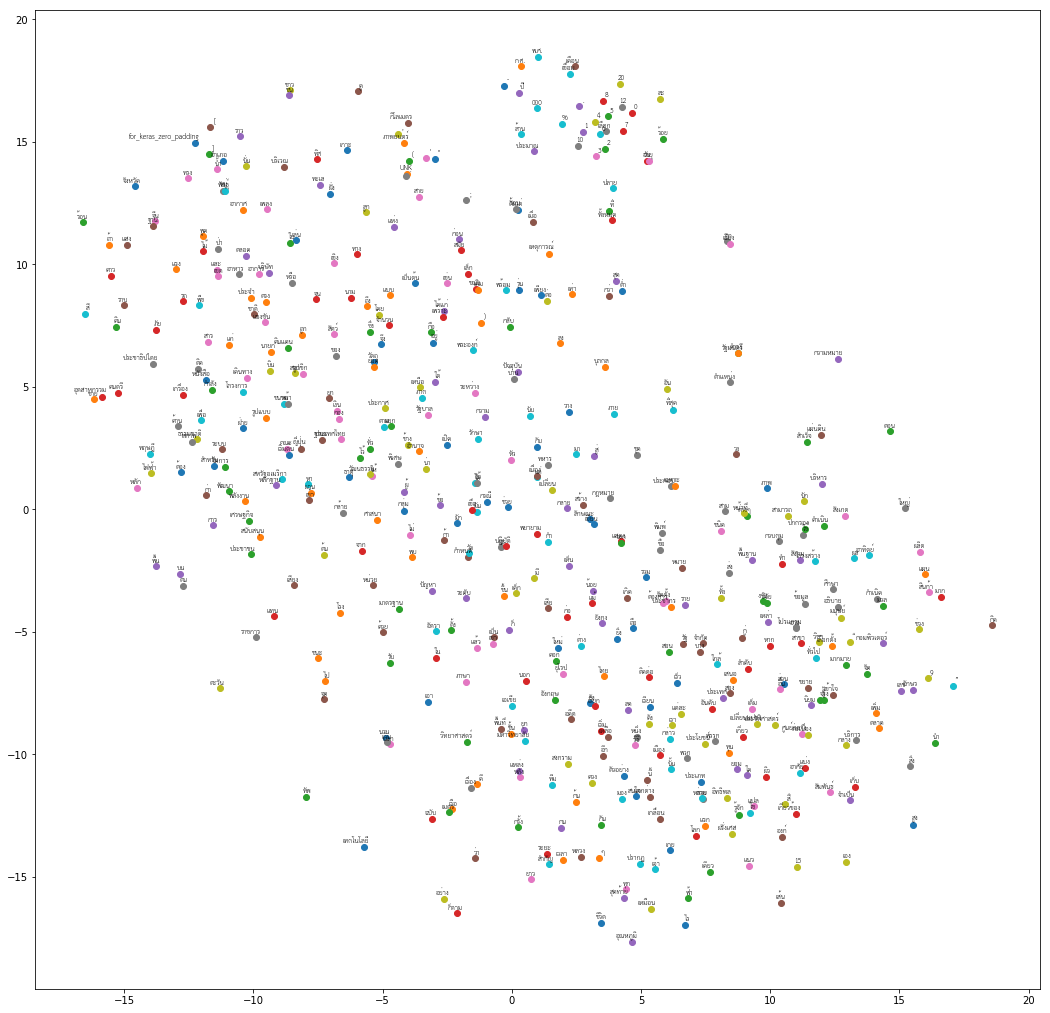

CPU times: user 19.5 s, sys: 3.96 s, total: 23.4 s
Wall time: 19.7 s


In [20]:
%%time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
# Step 5: Visualize the embeddings.
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename="tsne_plot.png"):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    fp = mpl.font_manager.FontProperties(family='TH Sarabun New')
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontproperties=fp)
    plt.show()
    plt.savefig(filename)





tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
plot_only = 500 #only top 500 words
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# TODO#5:capture the image and tell us what you observe 

In [21]:
#VISUALIZATION ON TENSORBOARD
#you need two files to represent data on tensorboard projector
#1 weights
#2 metadata 
import csv
with open('/data/weights.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerows(final_embeddings[:10000])

with open('/data/metadata.tsv', 'w') as tsvfile:
    for i in range(10000):
        tsvfile.write(reverse_dictionary[i]+"\n")

# Step 6: Evaluation

## <font color='blue'>Homework Question6:</font>
<font color='blue'>
Use the word embeddings from the skip-gram model as pre-trained weights in a classification model. Compare the result the with the same classification model that does not use the pre-trained weights. 
</font>


In [25]:
all_news_filepath = glob.glob('/home/ekapolc/HW3/BEST2010/training_set/news/*.txt')
all_novel_filepath = glob.glob('/home/ekapolc/HW3/BEST2010/training_set/novel/*.txt')
all_article_filepath = glob.glob('/home/ekapolc/HW3/BEST2010/training_set/article/*.txt')
all_encyclopedia_filepath = glob.glob('/home/HW3/ekapolc/BEST2010/training_set/encyclopedia/*.txt')

In [26]:
#preparing data for the classificaiton model
#In your homework, we will only use the first 2000 words in each text file
#any text file that has less than 2000 words will be padded
#reason:just to make this homework feasible under limited time and resource
max_length = 2000
def word_to_index(word):
    if word in dictionary:
        return dictionary[word]
    else:#if unknown
        return dictionary["UNK"]


def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data = prep_data()
train_data = input_data[:int(len(input_data)*0.6)]
val_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
test_data = input_data[int(len(input_data)*0.8):]

train_input = [data[0] for data in train_data]
train_input = sequence.pad_sequences(train_input, maxlen=max_length) #padding
train_target = [data[1] for data in train_data]
train_target=to_categorical(train_target, num_classes=4)



val_input = [data[0] for data in val_data]
val_input = sequence.pad_sequences(val_input, maxlen=max_length) #padding
val_target = [data[1] for data in val_data]
val_target=to_categorical(val_target, num_classes=4)

test_input = [data[0] for data in test_data]
test_input = sequence.pad_sequences(test_input, maxlen=max_length) #padding
test_target = [data[1] for data in test_data]
test_target=to_categorical(test_target, num_classes=4)

del input_data, val_data,train_data, test_data

In [27]:
#the classification model
#TO DO#6 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
cls_model = Sequential()
cls_model.add(Embedding(len(dictionary), 32, input_length=max_length,mask_zero=True))
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2000, 32)          356160    
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
Total params: 362,532
Trainable params: 362,532
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 238 samples, validate on 80 samples
Epoch 1/10
238/238 [==============================] - 45s - loss: 1.2779 - acc: 0.4706 - val_loss: 1.0895 - val_acc: 0.4750
Epoch 2/10
238/238 [==============================] - 45s - loss: 1.0066 - acc: 0.5000 - v

In [28]:
SkipGram.load_weights('/data/my_skipgram32_weights-hw.h5')

In [29]:
embeddingMod = Embedding(len(dictionary),32,input_length = max_length,mask_zero= True)
embeddingMod.build((None,))
embeddingMod.set_weights([np.array(SkipGram.get_weights()[0])])

cls_model_2 = Sequential()
cls_model_2.add(embeddingMod)
cls_model_2.add(GRU(32))
cls_model_2.add(Dropout(0.5))
cls_model_2.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model_2.summary()
print('Train...')
cls_model_2.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2000, 32)          356160    
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 132       
Total params: 362,532
Trainable params: 362,532
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 238 samples, validate on 80 samples
Epoch 1/10
238/238 [==============================] - 44s - loss: 1.2020 - acc: 0.3950 - val_loss: 1.0867 - val_acc: 0.5125
Epoch 2/10
238/238 [==============================] - 44s - loss: 1.0819 - acc: 0.4664 - v